# Laboratorio de regresión logística

|                |   |
:----------------|---|
| **Nombre**     |  Paola A. Figueroa Álvarez |
| **Fecha**      |  4/oct/2025 |
| **Expediente** |  751310 | 

La regresión logística es una herramienta utilizada para predecir respuestas cualitativas. Al igual que la regresión lineal, es un método sencillo que sirve como un punto de partida para técnicas más avanzadas. Por ejemplo, lo que se conoce como *redes neuronales* o *red de perceptrones multicapa* no es más que una estructura de regresiones logísticas que se alimentan entre sí.

1. Descarga el archivo de créditos y carga los datos (Default.csv). Utiliza `pandas`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data= pd.read_csv("/Users/paofigueroa/Documents/sem 5/Lab de aprendizaje estadístico/Default.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


2. Utiliza el comando `obj.head()`, donde `obj` es el nombre que le diste a los datos del archivo.

In [3]:
data.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138950
3,No,No,529.250605,35704.493940
4,No,No,785.655883,38463.495880


El comando head arroja los primeras *n* líneas (por defecto 5) de los datos que están en el DataFrame.

3. Utiliza el comando `obj.describe()`.

In [4]:
data.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729275
max,2654.322576,73554.233500


El comando describe toma las columnas que tienen datos numéricos y saca datos estadísticos comunes:
- *n*
- media
- desviación estándar
- valor mínimo
- primer cuartil
- mediana
- tercer cuartil
- valor máximo

3. Vistos estos datos, ¿qué columnas existen en el DataFrame? ¿Qué tipo de datos contienen?

contiene información sobre cuatro variables clave. La variable dependiente o de respuesta es default, de tipo categórico (Yes/No), que indica si el cliente incurrió en incumplimiento de pago. Las variables predictoras incluyen student, también categórica (Yes/No), que señala si el cliente es estudiante; balance, una variable numérica (float) que representa el saldo promedio de la tarjeta de crédito del cliente; e income, una variable numérica (float) que indica el ingreso anual del cliente en dólares.

4. Configura el tipo de dato de las columnas `default` y `student` para cambiarlos a variables categóricas.

`data[columna] = data[columna].astype("category")`

In [9]:
data.columns
data['default']=data['default'].astype("category")
data['student']=data['student'].astype("category")

Imagina que trabajas en un banco y que se te entregan estos datos. Tu objetivo es crear un modelo que ayude a predecir si una persona que solicita un crédito lo va a pagar. Exploremos los datos un poco más antes de crear un modelo.

Veamos primero cómo es la distribución de los valores cuando una persona dejó de pagar y cuando siguió pagando. `Default` es el término utilizado para cuando una persona dejó de pagar.

5. Crea una gráfica de caja para las columnas `income` y `balance`, con los datos agrupados con la columna `default`. Utiliza el comando `obj.boxplot(column=____, by=_____)`

<Axes: title={'center': 'income'}, xlabel='default'>

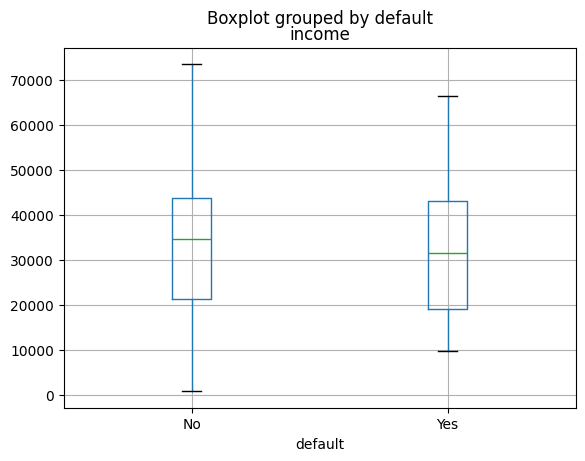

In [10]:
data.boxplot(column='income', by='default')

El gráfico de caja y bigotes muestra que la mediana del ingreso anual es un poco similar entre los clientes que no entraron en incumplimiento (No) y los clientes que sí lo hicieron (Yes), con la mediana en ambos grupos rondando los $40,000. La distribución del ingreso para los clientes en default (Yes) es ligeramente más dispersa, pero en general, el ingreso no presenta una diferencia marcada, indicando que, probablemente esta variable no ayuda mucho a distinguir los clientes que pagan o que incumplen su deuda. 

<Axes: title={'center': 'balance'}, xlabel='default'>

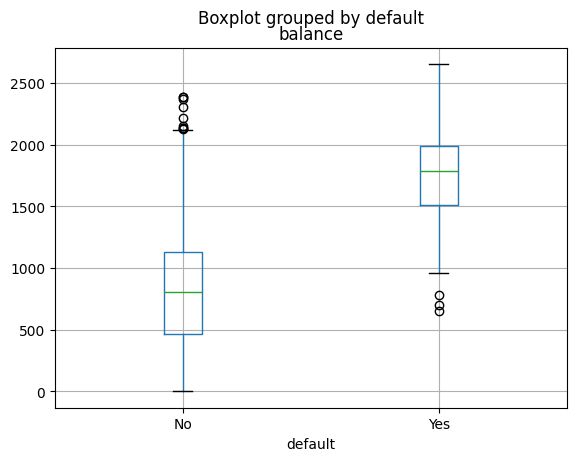

In [11]:
data.boxplot(column='balance', by='default')

Aquí sí vemos una diferencia notable entre los grupos. La mediana del saldo es significativamente más alta para los clientes que sí entraron en incumplimiento en comparación con aquellos que no lo hicieron. La distribución del saldo para los clientes en default está desplazada hacia valores mayores y también presenta una mayor dispersión. Además, para quienes no hicieron incumplimiento, hay outliers en valores más altos, mientras que para los que sí incumplieron, los outliers son para un balance menor. Quizás esto indique una menor capacidad de pago incluso cuando la deuda es pequeña, ya sea desde problemas de liquidez, emergencias o casos extremos

6. Crea una gráfica de dispersión donde el eje *x* sea la columna `balance` y el eje *y* la columna `income`. Utiliza el comando `obj.plot.scatter(x, y, c="default", colormap="PiYG_r", alpha=0.5)`.

<Axes: xlabel='balance', ylabel='income'>

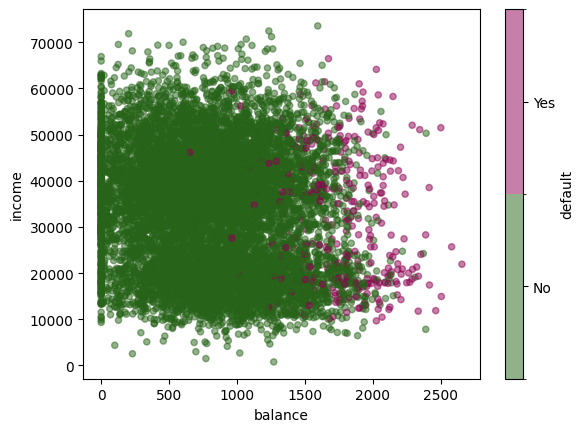

In [13]:
data.plot.scatter('balance','income',c='default', colormap='PiYG_r', alpha=0.5)

En esta gráfica, de acuerdo el saldo promedio (balance) e ingresos, podemos ver que a mayor saldo, hay una mayor presencia de que sí incumplieron. Como tal, hay una mayor dispersión para los que sí incumplieron, dejándolos en el extremo de la gráfica, donde el saldo de tarjeta es mayor y, en algunos casos, el ingreso también. 

La regresión (lineal o logística) se usa para encontrar una línea que ajuste los datos para tomar una decisión. La línea que buscamos en regresión logística es aquella que nos ayude a separar las diferentes categorías. 

<img style="float: left; " src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/10/decision_boundary_curve.jpg" width="400px" />


## Regresión logística simple

Creemos un modelo simple donde sólo utilizamos una de los factores para predecir una respuesta. Quiero conocer la probabilidad de que una persona deje de pagar su crédito dado el balance que tiene en su cuenta.

$$ P(\text{default}=\text{Yes}|\text{balance}) $$

Por el momento la columna default no contiene valores numéricos, por lo que hay que transformar los datos. Como default es nuestra variable de respuesta (lo que queremos predecir) podemos nombrarla *y*.

Ejecuta el código `y = obj["default"] == "Yes"`. Extrae el factor `balance` en una variable *x*.

In [42]:
y_transformada= data['default']=='Yes'
y_transformada

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: default, Length: 10000, dtype: bool

In [43]:
x = data['balance']
x

0        729.526495
1        817.180407
2       1073.549164
3        529.250605
4        785.655883
           ...     
9995     711.555020
9996     757.962918
9997     845.411989
9998    1569.009053
9999     200.922183
Name: balance, Length: 10000, dtype: float64

Crea un gráfico de dispersión donde el eje *x* sea `balance` y el eje *y* sea `default` transformado.

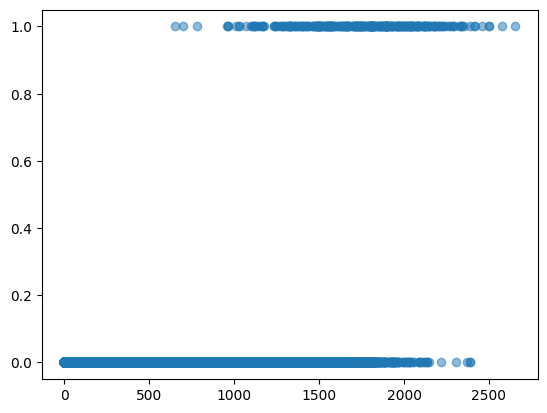

In [45]:
plt.scatter(x, y_transformada, alpha=0.5)

La gráfica de dispersión ilustra la relación positiva entre el saldo de la tarjeta de crédito y la probabilidad de incumplimiento de pago. La gran mayoría de los puntos se agrupan en la línea inferior, confirmando que solo una pequeña fracción de los clientes incurre en default. Pero, a medida que el Balance aumenta (moviéndose hacia la derecha), la dispersión de los puntos en la línea superior se hace mucho más densa. Aquí podemos comprobar la lógica de que a mayor saldo, mayor es la probbilidad de que alguien incumpla su pago.

La línea que utilizaremos para predecir la probabilidad es:

$$ p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} $$

Para nuestro ejemplo de pagos y balance:

$$ P(\text{default}=1|\text{balance}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  \text{balance})}} $$

Buscamos maximizar la probabilidad de que el modelo tome decisiones correctas. Es decir, que cuando `default` fue verdadero, que la predicción sea 100%, y que cuando `default` fue falso que la predicción sea 0%.

$$ \Pi_{i:y_i=1} p(x_i) \Pi_{i':y_{i'}} (1-p(x_{i'})) $$

La función de costo ya simplificada es la siguiente:

$$ J(\vec{\beta}) = -  \sum_{i=1}^n{[y_i \ln{(\hat{p}(x_i))} + (1-y_i)\ln{(1 - \hat{p}(x_i))}]}$$

Utiliza la clase `LogisticRegression` del módulo `linear_model` de la librería `sklearn` para estimar los parámetros del modelo.

In [40]:
from sklearn.linear_model import LogisticRegression

In [46]:
X = x.values.reshape(-1, 1)
y = y_transformada.astype(int)

Muchos aspectos de la regresión logística son similares a la regresión lineal. Podemos medir la precisión de nuestros estimados calculando sus errores estándar. El objetivo de calcular estos errores es asegurar que hay una relación estadísticamente significativa entre el factor y la variable de respuesta.

Los errores estándar se obtienen con el siguiente procedimiento:

1. Calcula las predicciones utilizando los $\beta_0$ y $\beta_1$ encontrados.

In [48]:
model = LogisticRegression()
model.fit(X, y)
print("Intercepto: ",model.intercept_)
print("Coeficiente: ", model.coef_)

Intercepto:  [-10.65132824]
Coeficiente:  [[0.00549892]]


In [52]:
y_pred= model.predict_proba(X)[:, 1]
y_pred

array([1.30568146e-03, 2.11259754e-03, 8.59474814e-03, ...,
       2.46651596e-03, 1.16759635e-01, 7.14476480e-05], shape=(10000,))

2. Idealmente la probabilidad debería ser 100% o 0%. Si alguna predicción no fue absoluta significa que hay incertidumbre. Calcula $p(1-p)$ para todas tus predicciones.

In [53]:
p = y_pred
p_menos1 = p * (1 - p)
p_menos1

array([1.30397665e-03, 2.10813447e-03, 8.52087844e-03, ...,
       2.46043226e-03, 1.03126823e-01, 7.14425432e-05], shape=(10000,))

3. Crea una matriz vacía y llena la diagonal con las probabilidades encontradas.

`V = np.diagflat(*p(1-p)*)`

In [55]:
V = np.diagflat(p_menos1)
V

array([[1.30397665e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.10813447e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.52087844e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.46043226e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.03126823e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.14425432e-05]],
      shape=(10000, 10000))

4. Calcula la matriz de covarianza. (Dado que X es la matriz que contiene todos los factores)

`cov = np.linalg.inv(X.T @ V @ X)`

In [56]:
cov=np.linalg.inv(X.T@ V@ X)
cov

array([[1.71411499e-09]])

5. Los valores en la diagonal de la matriz de covarianza corresponden a la varianza de los factores. Utiliza los valores de la diagonal para calcular el error estándar.

`se = np.sqrt(np.diag(cov))`

In [57]:
se=np.sqrt(np.diag(cov))
se

array([4.14018718e-05])

Ahora, revisemos si los estimados de nuestros coeficientes demuestran que hay una relación significativa entre los factores y la respuesta.

Calculamos el estadístico *z*

$$ z_j = \frac{\hat{\beta_j}}{\text{SE}(\hat{\beta_j})} $$

In [58]:
z = model.coef_/ se
z

array([[132.81804209]])

Utilizamos el estadístico *z* para encontrar el *p-value*.

`from scipy.stats import norm`

`p_value = 2 * (1 - norm.cdf(abs(z_statistic)))`

In [59]:
from scipy.stats import norm

In [60]:
p_value= 2* (1- norm.cdf(abs(z)))
p_value

array([[0.]])

¿Es significativa la relación de los factores con la variable de respuesta?

Sí es muy significativa, pues el p-value es de 0, lo que significa que no es de chiripa, además el error estándar es mínimo junto con la matriz de covarianza, indicando que estos factores sí influyen en la variable de respuesta.

Repite el procedimiento con el factor `student`. 
1. Transforma el factor de {"Yes", "No"} a {1, 0}.
2. Estima los coeficientes. 
3. Calcula el error estándar de tus estimaciones.
   1. Usa tu modelo para encontrar $\hat{p}(X)$
   2. Calcula el error $p(1-p)$
   3. Calcula la matriz de covarianza
   4. Extrae el error estándar
5. Argumenta si los factores son significativos utilizando el *p-value*.
   1. Utiliza el error estándar para calcular el estadístico *z*
   2. Calcula el *p-value*
   3. ¿Son significativos?


In [61]:
y_transform = (data["default"] == "Yes").astype(int)
X_student = data["student"].cat.codes.values.reshape(-1, 1)

In [62]:
model_student = LogisticRegression()
model_student.fit(X_student, y_transform)

print("Intercepto :", model_student.intercept_)
print("Coeficiente student :", model_student.coef_)

Intercepto : [-3.50257249]
Coeficiente student : [[0.39620888]]


In [65]:
y_pred2 = model_student.predict_proba(X_student)[:, 1]

p2 = y_pred2
p_menos1_2 = p2 * (1 - p2)

V2 = np.diag(p_menos1_2)
V2

array([[0.0283842 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04100979, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0283842 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0283842 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0283842 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04100979]], shape=(10000, 10000))

In [66]:
#matriz de covarianza
cov2 = np.linalg.inv(X_student.T @ V2 @ X_student)
print("Matriz de covarianza:", cov2)

#Error estándar
se2 = np.sqrt(np.diag(cov2))
print("Error estándar:", se2)

#Estadístico z
z2 = model_student.coef_[0] / se2
print("z:", z2)

#p-value
p_value2 = 2 * (1 - norm.cdf(abs(z2)))
print("p-value:", p_value2)

Matriz de covarianza: [[0.00828275]]
Error estándar: [0.09100963]
z: [4.35348308]
p-value: [1.33991442e-05]


Interpretación: Estos resultados muestran que la relación entre ser estudiante y la probabilidad de incumplimiento es estadísticamente significativa, ya que el p-value es mucho menor que 0.05. Esto significa que ser estudiante influye de manera importante en la probabilidad de caer en default. Dado que el coeficiente es positivo, los estudiantes tienden a presentar mayor probabilidad de incumplimiento en comparación con quienes no lo son. 

## Regresión logística múltiple

Considera ahora el caso de múltiples factores. Intentemos predecir si la persona dejará de pagar su crédito utilizando toda la información que tenemos disponible. I.e.

$$ P(\text{default}=1|\text{balance}, \text{income}, \text{student}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  \text{balance} + \beta_2 \text{income} + \beta_3 \text{student})}} $$

1. Utiliza `LogisticRegression` para estimar los coeficientes.
2. Calcula el error estándar de tus estimaciones.
3. Argumenta si los factores son significativos utilizando el *p-value*. 

In [76]:
# 1. Transformar la variable categórica 'student' a dummy (0 o 1)
data['student_Yes'] = pd.get_dummies(data['student'], drop_first=True)
X3 = data[['balance', 'income', 'student_Yes']]
Y= data['default']=='Yes'

In [77]:
X_multi = LogisticRegression()
X_multi.fit(X3, Y)

print("Intercepto :", X_multi.intercept_)
print("Coeficiente student :", X_multi.coef_)

Intercepto : [-10.90180766]
Coeficiente student : [[ 5.73061121e-03  3.96162485e-06 -6.12572904e-01]]


In [80]:
y_pred3 = X_multi.predict_proba(X3)[:, 1]

p3 = y_pred3
p_menos1_3 = p3 * (1 - p3)

V3 = np.diag(p_menos1_3)
V3

array([[1.43254585e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.12977048e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.62492519e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.93606816e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.24787043e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.37599123e-05]],
      shape=(10000, 10000))

In [82]:
#matriz de covarianza
X3 = X3.astype(float)
cov3 = np.linalg.inv(X3.T @ V3 @ X3)
print("Matriz de covarianza:", cov3)

#Error estándar
se3 = np.sqrt(np.diag(cov3))
print("Error estándar:", se3)

#Estadístico z
z3 = X_multi.coef_[0] / se3
print("z:", z3)

#p-value
p_value3 = 2 * (1 - norm.cdf(abs(z3)))
print("p-value:", p_value3)

Matriz de covarianza: [[ 2.58276014e-08 -9.30418954e-10 -2.77238240e-05]
 [-9.30418954e-10  3.77101071e-11  9.23727122e-07]
 [-2.77238240e-05  9.23727122e-07  4.39895228e-02]]
Error estándar: [1.60709681e-04 6.14085557e-06 2.09736794e-01]
z: [35.65815816  0.64512588 -2.92067449]
p-value: [0.         0.51884561 0.00349275]


Interpretación:

¿Cómo sabemos qué tan bueno es el modelo? Hay cuatro posibles casos para un problema de clasificación simple:
- Era sí y se predijo sí. (Verdadero positivo **TP**)
- Era sí y se predijo no. (Falso negativo **FN**)
- Era no y se predijo sí. (Falso positivo **FP**)
- Era no y se predijo no. (Verdadero negativo **TN**)

De esos cuatro casos hay dos donde el modelo es correcto y dos donde el modelo no es correcto.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*IuymDnZpRlkat0qejE26Nw.png)

1. Menciona dos ejemplos donde consideres que un falso positivo sea un peor resultado que un falso negativo.

Aprobar un crédito a alguien que en realidad no lo puede pagar puede generar pérdidas significativas, mientras que negar el crédito a un cliente confiable (falso negativo) solo representa una oportunidad perdida.

Si una prueba médica dice que un paciente tiene una enfermedad grave, cuando en realidad no la tiene (falso positivo), podría someterse a cirugías o tratamientos innecesarios que ponen en riesgo su salud

2. Menciona dos ejemplos donde consideres que un falso negativo sea un peor resultado que un falso positivo.

Si no suena una alarma de incendio cuando hay humo real (falso negativo), puede provocar un incendio grave. Si suena sin que haya humo (falso positivo), solo molesta un poco y hace que revises la cocina.

Si waze no detecta un accidente real en tu ruta (falso negativo), puedes quedarte atrapado o retrasarte mucho. Si te alerta de un accidente que no existe (falso positivo), solo haces un desvío innecesario, pero no hay daño grave.

Si el celular no te avisa que la batería está por agotarse (falso negativo), podría apagarse en un momento importante. Si te avisa cuando todavía queda batería suficiente (falso positivo), solo te adelantas a cargarlo sin necesidad inmediata.

## Referencia

James, G., Witten, D., Hastie, T., Tibshirani, R.,, Taylor, J. (2023). An Introduction to Statistical Learning with Applications in Python. Cham: Springer. ISBN: 978-3-031-38746-3